In [1]:
#---
import os
import shutil
from collections import defaultdict
import numpy as np 
from glob import glob
import os
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
#---
import torch.nn as nn 
import datetime
import logging
import easydict
#---
from lightning.fabric import Fabric
import lightning as L

#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

#---------------------------------
#-- args operation
EXEC_VER = 85 # zero means test 
DDP = False
TASK = "EDGE"
#-- args modeling 
MODEL_NAME = "EDGE_NET"
CRITERION = "BCE"
BATCH_SIZE = 4
LEARNING_RATE = 1e-5
#-- args train
DEVICE = "cuda:0"
DEVICES = [0,1,2,3]
RESUME = False
SAVE_EPOCH = 20
EPOCHS = 140
DATA_SHUFFLE = True
#-- args category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)
    }
#---------------------------------


In [2]:
%load_ext autoreload
%autoreload 2
# load dataset 
import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_utils
import RS_models

In [3]:
#-- dataset
train_dataset = RS_dataset.Seg_RS_dataset_edge_v4(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP)
dataloader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=DATA_SHUFFLE, collate_fn=train_dataset.collate_fn)

#--- model 
model = RS_models.Edge_Net(input_channel=len(ISAID_PALETTE_SHIP.keys()), output_channel=1)

In [4]:
label, edge = train_dataset.__getitem__(0)

In [5]:
label.shape

torch.Size([3, 256, 256])

In [6]:
edge.shape

torch.Size([1, 256, 256])

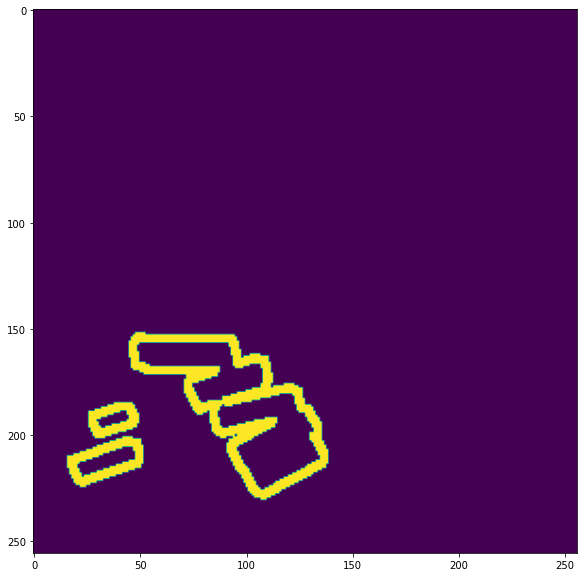

In [7]:
RS_utils.torch_display(edge,batch=False)

In [8]:
model = model.eval()
pred = model(label)

In [9]:
pred.shape

torch.Size([1, 256, 256])

In [10]:
pred = pred.detach().cpu()

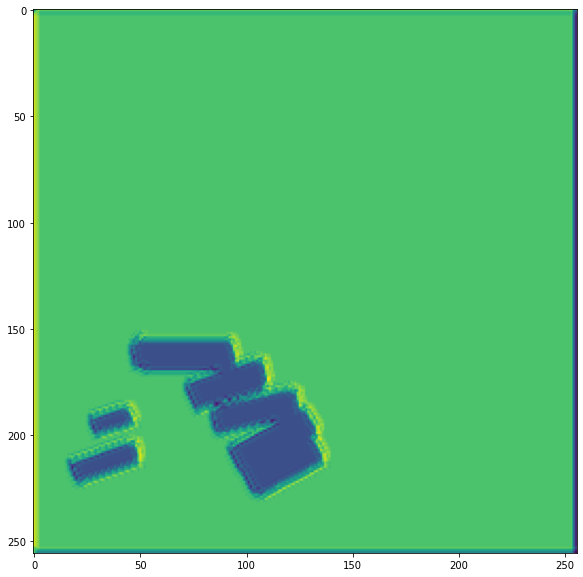

In [11]:
RS_utils.torch_display(pred,batch=False)

In [12]:
# sigmoid 
pred_ = torch.sigmoid(pred)

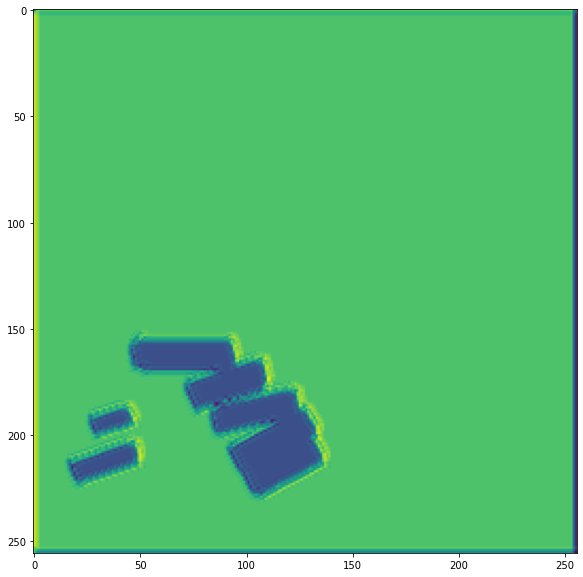

In [13]:
RS_utils.torch_display(pred_,batch=False)

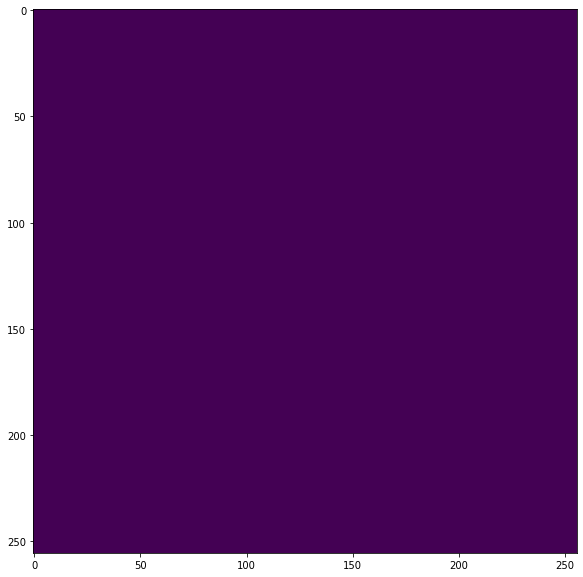

In [24]:
part = pred.clone()
#map = part > 1
map = torch.sigmoid(part)
map = map > 0.1
#print(torch.mean(map))
RS_utils.torch_display(map,batch=False)

In [28]:
pred > 0.01

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True, False]]])